# Setup workspace, load data, and calculate needed variables¶

### Import packages and setup options/directories

In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from datetime import datetime
from datetime import time, timedelta
import itertools
from math import pi, cos, sin, acos
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
import numpy as np
import os
import pandas as pd
import re
from scipy.interpolate import interp1d
from scipy import interpolate
from shapely.geometry.polygon import LinearRing
from skimage import feature
import warnings
import xarray as xr

In [2]:
# - Set data path
dpath = '/opt/acoustic-variability/data/'

In [3]:
# - Set saved out figure path
figpath = '/opt/acoustic-variability/clean_version/figures/between20Nand20S/'

In [4]:
warnings.filterwarnings('ignore')

### Load ADCP metadata

In [5]:
%run helper_notebooks/create_JASADCP_metadata_df.ipynb

# of files w/o bandwidth: 57
NB-VM-150         1088
OS-38              519
OS-75              363
WH-300             188
OS-150              26
NB-VM-300           25
NB-VM-75            14
BB-VM-150           13
OS-II-38             6
WH-Mariner-300       3
NB-DR-150            3
WH-Mariner-600       1
DCP4400A             1
OS-II-75             1
WH-1200              1
Name: instrument_name, dtype: int64


### Define fxns

In [6]:
%run helper_notebooks/setup_Sv_compute.ipynb

In [7]:
%run helper_notebooks/fxns_Sv_compute.ipynb

# Keep Tropical Pacific cruises only

In [8]:
# - Define Tropical Pacific lon/lat limits
# (actual east-west boxes defined below are smaller than this region)
lat_abs_lim = 20
lon_w_lim = 120 # 120E, had 100E before but got too many Ind Oc
lon_e_lim = 285 # 75W 

# - Keep only metadata from Tropical Pacific
df['in_tp'] = "" # initialize; later 0 = in tropical pac, 1 = not
df.reset_index(inplace=True, drop=True)
for ifile in np.arange(0,len(df)):
    fname = df['fname'][ifile]
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    lon = nc['lon'].dropna(dim='time').values
    lat = nc['lat'].dropna(dim='time').values
    lon[lon<0] = lon[lon<0] + 360
    if (abs(lat) <= lat_abs_lim).any() and ((lon > lon_w_lim) & (lon < lon_e_lim)).any():
    # if any of the cruises' profs are within the TP limits
        df.at[ifile,'in_tp'] = 1
    else:
        df.at[ifile,'in_tp'] = 0
dfnow = df[df['in_tp']==1]

# - Skip ifile = 25 b/c that is weird DCP4400A instrument 
dfnow = dfnow[dfnow['instrument_name']!='DCP4400A']
dfnow.reset_index(inplace=True, drop=True)

# - How many files?
fnamesnow = dfnow['fname'].values
print('# Tropical Pacific files:',len(fnamesnow))

# Tropical Pacific files: 547


# Divide Tropical Pacific into east and west + further decide on files to keep + standard depths

In [9]:
pg_thresh = 0 # % good pings threshold (get rid of pts w/ pg<pg_thresh)
lat_nmost = 20
lat_smost = -20 
lon_w_wmost = 100 # 100 = 100E
lon_w_emost = 190 # 190 = 150W 
lon_e_wmost = 220 # 220 = 140W
lon_e_emost = 285 # 190 = 75W 
std_depths = np.arange(0,1000+25,25)
timemin = dfnow['cruise_beg_date'].min()
timemax = dfnow['cruise_beg_date'].max()
eqpacncfoldername = 'eqpac_Sv_ncfiles_v1/'
# eqpacncfoldername is folder within data dir to save generated nc files to

# Plot Tropical Pacific cruises + east/west division boundaries

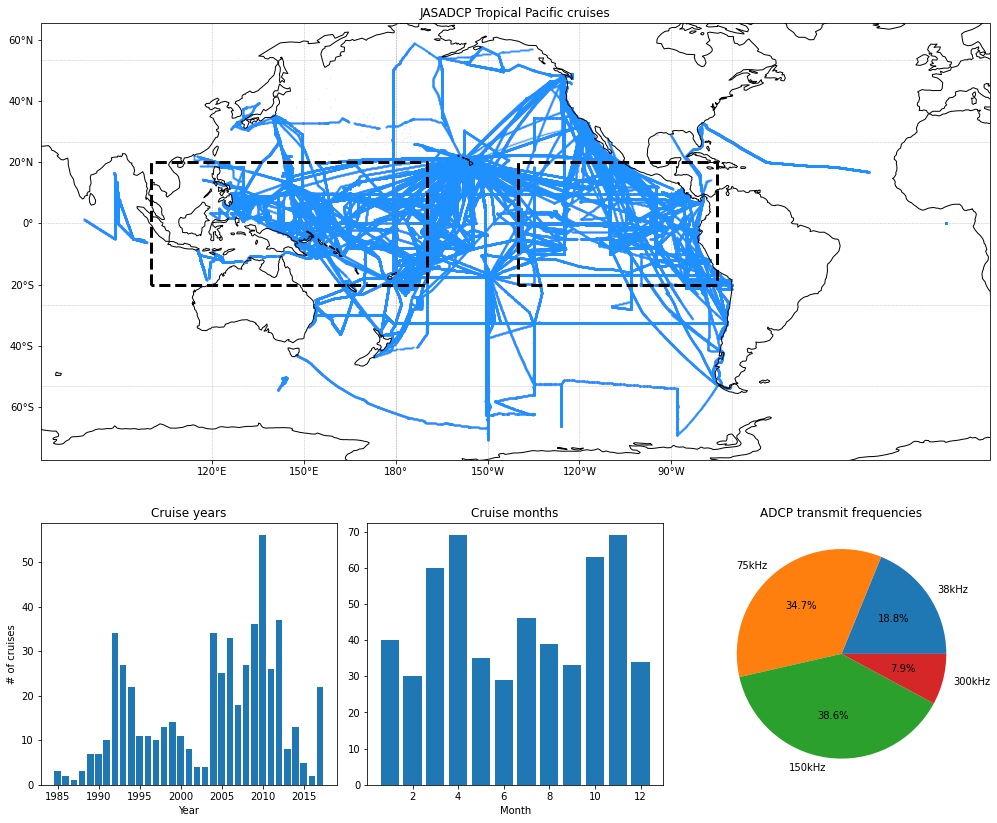

In [10]:
#%%script false --no-raise-error
# If you want to run this cell,
# comment out the line above

fig = plt.figure(figsize=(14,12))

# - Plot map w/ cruise tracks going through Tropical Pacific (TP)
ax0 = plt.subplot2grid((3,3),(0,0),colspan=3,rowspan=2,
    projection=ccrs.PlateCarree(central_longitude=200))
ax = ax0; exec(open("helper_scripts/create_map_bgs.py").read())
for fname in fnamesnow:
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    ax0.scatter(nc['lon'] ,nc['lat'], c='dodgerblue',
                s=0.5, alpha=0.1, transform=ccrs.PlateCarree());
ax0.set_xlabel(''); ax0.set_ylabel(''); ax0.set_title('JASADCP Tropical Pacific cruises')
wboxlons = [lon_w_wmost, lon_w_wmost, lon_w_emost, lon_w_emost]
wboxlats = [lat_smost, lat_nmost, lat_nmost, lat_smost]
wbox = LinearRing(list(zip(wboxlons, wboxlats)))
ax0.add_geometries([wbox], ccrs.PlateCarree(), facecolor='none', edgecolor='black',
                   linestyle='--', linewidth=3)
eboxlons = [lon_e_wmost-360, lon_e_wmost-360, lon_e_emost-360, lon_e_emost-360]
eboxlats = [lat_smost, lat_nmost, lat_nmost, lat_smost]
ebox = LinearRing(list(zip(eboxlons, eboxlats)))
ax0.add_geometries([ebox], ccrs.PlateCarree(), facecolor='none', edgecolor='black',
                   linestyle='--', linewidth=3)

# - Plot histogram of TP cruise years
ax1 = plt.subplot2grid((3,3), (2,0))
ax1.hist(dfnow['cruise_beg_date'].dt.year,
         bins=np.arange(dfnow['cruise_beg_date'].dt.year.min()-
                        0.5,dfnow['cruise_beg_date'].dt.year.max()+0.5), rwidth=0.8)
ax1.set_title('Cruise years')
ax1.set_xlabel('Year'); ax1.set_ylabel('# of cruises')

# - Plot histogram of TP cruise months
ax2 = plt.subplot2grid((3,3), (2,1))
ax2.hist(dfnow['cruise_beg_date'].dt.month, bins=np.arange(0.5,13), rwidth=0.8)
ax2.set_title('Cruise months')
ax2.set_xlabel('Month'); #ax2.set_ylabel('# of cruises')

# - Plot pie chart of TP ADCP frequencies 
ax3 = plt.subplot2grid((3,3), (2,2))
labels = '38kHz', '75kHz', '150kHz', '300kHz'
sizes = [len(dfnow[dfnow['freq_round_kHz']==38]), len(dfnow[dfnow['freq_round_kHz']==75]),
         len(dfnow[dfnow['freq_round_kHz']==150]), len(dfnow[dfnow['freq_round_kHz']==300])]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
ax3.pie(sizes, labels=labels, autopct='%1.1f%%')
ax3.set_title('ADCP transmit frequencies')
ax3.set_aspect('equal', 'box')
fig.tight_layout()
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_map.png',
            bbox_inches='tight', pad_inches = 0, dpi = 300)

# Load/calc monthly ENSO time series

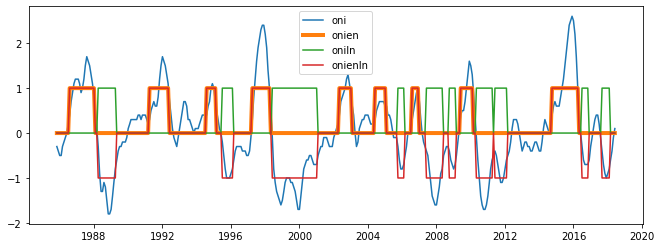

In [11]:
# - Load ONI 
dfoni = pd.read_csv(dpath+'oniindex1950_2018.txt',names=['Date','ONI']);

# - Define month fractions corresp to jan, feb, mar, etc. in the ONI txt file
monthfracs = [0,0.0834,0.1666,0.25,0.3334,0.4166,0.5,0.5834,0.6666,0.75,0.8334,0.9166];

# - Get ONI ts over desired timeframe
onibegmoidx = dfoni.index[dfoni['Date'] == (timemin.year + monthfracs[timemin.month-1])][0]
oniendmoidx = dfoni.index[dfoni['Date'] == (timemax.year + monthfracs[timemax.month-1])][0]
oni = dfoni['ONI'].iloc[onibegmoidx:(oniendmoidx+1)].values
onitime = pd.date_range(timemin.strftime('%Y-%m-01'), timemax.strftime('%Y-%m-01'), freq='MS')

# ---- Create EN/LN month classifications
onien = [0]*len(oni) # 1 = el nino month
oniln = [0]*len(oni) # 1 = la nina month
# - Classify El Nino months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]>=0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]<0.5:
        cmcounter=0;
    if cmcounter>=5:
        onien[imonth-cmcounter:imonth]=[1]*cmcounter;
# - Classify La Nina months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]<=-0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]>-0.5:
        cmcounter=0;
    if cmcounter>=5:
        oniln[imonth-cmcounter:imonth]=[1]*cmcounter;
        
# - Make everything into DataArrays
oni = xr.DataArray(oni, dims=('time'), coords={'time': onitime})
onien = xr.DataArray(onien, dims=('time'), coords={'time': onitime})
oniln = xr.DataArray(oniln, dims=('time'), coords={'time': onitime})
onienln = xr.zeros_like(onien, dtype='int')
onienln[onien==1] = 1 # el nino = 1
onienln[oniln==1] = -1 # la nina = -1

# - Check enso classifications
plotensoidx=1
if plotensoidx==1:
    fig = plt.figure(figsize=(11,4))
    plt.plot(onitime,oni)
    plt.plot(onitime,onien,linewidth=4)
    plt.plot(onitime,oniln)
    plt.plot(onitime,onienln)
    plt.legend(["oni","onien","oniln","onienln"])

# Compile Sv cruise-days

In [12]:
# - Set the below to 0 if compiled Sv cruise-day nc files
# don't yet exist for the east-west areas you've defined;
# set to 1 if these nc files do already exist 
loadSvcd = 0

In [13]:
if loadSvcd==0:
    
    # - Begin tracking how long this takes to run
    print(datetime.now().strftime("%H:%M:%S"))
    
    # - Initialize Sv matrices 
    # Keys: Svcd = Sv cruise-days,
    #       Svcd_raw_all = [Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e]
    #       Svcd_icd = counts # of cruise-days in each matrix/category
    Svcd_raw_all = [None,None,None,None,None,None]
    Svcd_icd = np.asarray([0,0,0,0,0,0])
    
    # ---- Loop through all cruises going through TP 
    for ifile in np.arange(0,len(fnamesnow)):
    
        # - Calculate Sv + get rid of times w/o lon and lat
        fname = fnamesnow[ifile]
        print(ifile,fname)
        ncfile = dpath + 'JASADCP/ncfiles/' + fname
        nc = xr.open_dataset(ncfile)
        exec(open("helper_scripts/calc_Sv.py").read()) # var calced = Sv
        
        # - Compute solar time
        solar_time = [None]*len(Sv['time'])
        for itime in range(0,len(Sv['time'])):
            lon = float(Sv_lon[itime])
            lat = float(Sv_lat[itime])
            utc_time = pd.to_datetime(Sv['time'].values[itime])
            solar_time[itime], _ = get_solar_time_and_angles(utc_time,lon,lat)
        Sv['time'] = solar_time; Sv_pflag['time'] = solar_time
        Sv_pg['time'] = solar_time; Sv_depth['time'] = solar_time
        Sv_lon['time'] = solar_time; Sv_lat['time'] = solar_time
        
        # - See how many days the cruise spans
        all_days = pd.to_datetime(Sv['time'].values).normalize().unique()
        print('# of days:',len(all_days))
        
        # ---- Append cruise-day to appropriate matrix w/ standardized depths
        tot_cdays = len(all_days)
        # - Loop over each day in given cruise file  
        for iday in range(0,tot_cdays):
            daynow = all_days[iday]; daystrnow = daynow.strftime('%Y-%m-%d') 
            # - Keep only unflagged Sv values w/ % good pings above set threshold
            Svnow = Sv.where((Sv_pg>pg_thresh) & (Sv_pflag==0)).sel(time=daystrnow)
            # - Compute Sv hourly means to reduce data size --> 24 time points per day
            Svhrnow = Svnow.groupby('time.hour').mean(dim='time') 
            # - Get hour-averaged depths associated w/ Sv values
            Svdepthhrnow = Sv_depth.sel(time=daystrnow).groupby('time.hour').mean(dim='time')
            # ---- Standardize hourly depths
            Svhrnew = np.full([len(Svhrnow['hour']), len(std_depths)], np.nan)
            ihr = 0
            # - Loop over each hour to standardize depths at each hour
            # via 1-D interpolation of Sv on old depths to std depths
            for hrnow in Svhrnow['hour']:
                old_depths = Svdepthhrnow.sel(hour=hrnow)
                old_Sv = Svhrnow.sel(hour=hrnow)
                good_idxs = np.where(~((std_depths>old_depths.max().values) | (std_depths<old_depths.min().values)))
                f = interp1d(old_depths, old_Sv)
                new_Sv = np.array([None]*len(std_depths))
                new_Sv[good_idxs] = f(std_depths[good_idxs])
                new_Sv = new_Sv.astype(float)
                Svhrnew[ihr,:] = new_Sv 
                ihr = ihr+1
            # ---- Append Sv cruise-day to appropriate matrix (east/west, EN/LN)
            # - Get the mean lon and lat of the given day's cruise track
            Svlonnow = Sv_lon.sel(time=daystrnow).mean()
            Svlatnow = Sv_lat.sel(time=daystrnow).mean()
            # - Get the ENSO phase of the given day (EN, LN, or nothing)
            onitidxnow = (onienln['time'].dt.year==daynow.year) & (onienln['time'].dt.month==daynow.month)
            enlnnow = onienln[onitidxnow] # 1=EN, -1=LN, 0=nothing (NA)
            # - Determine whether the mean lon,lat of the day's cruise
            #   track is in the user-defined east or west boxes
            in_w = (Svlonnow>lon_w_wmost) & (Svlonnow<lon_w_emost) & (Svlatnow<lat_nmost) & (Svlatnow>lat_smost)
            in_e = (Svlonnow>lon_e_wmost) & (Svlonnow<lon_e_emost) & (Svlatnow<lat_nmost) & (Svlatnow>lat_smost)
            # - Append current Sv cruise-day into appropriate matrix
            # Key: Svcd_raw_all = [Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e],
            #      midx = matrix index
            if in_w | in_e:
                if enlnnow==1: # EN
                    midx = 0 if in_w else 1
                elif enlnnow==-1: # LN
                    midx = 2 if in_w else 3
                elif enlnnow==0: # NA
                    midx = 4 if in_w else 5
                Svcdnow = np.full([24, len(std_depths)], np.nan)
                Svcdnow[Svhrnow['hour'].values, :] = Svhrnew
                if Svcd_icd[midx]==0:
                    Svcd_raw_all[midx] = Svcdnow 
                else:
                    Svcd_raw_all[midx] = np.dstack([Svcd_raw_all[midx], Svcdnow])
                Svcd_icd[midx] += 1
                
    # - End tracking how long this takes to run
    print(datetime.now().strftime("%H:%M:%S"))
    
    # - Clean up and package Svcd variables into DataArrays
    # Key: Svcd_raw_all = [Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e]
    midxnow = 0
    Svcd_raw_enw_xr = xr.DataArray(Svcd_raw_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_raw_all[midxnow].shape[2])})
    Svcd_raw_enw_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_el_nino_WEP.nc')
    
    midxnow = 1
    Svcd_raw_ene_xr = xr.DataArray(Svcd_raw_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_raw_all[midxnow].shape[2])})
    Svcd_raw_ene_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_el_nino_EEP.nc')
    
    midxnow = 2
    Svcd_raw_lnw_xr = xr.DataArray(Svcd_raw_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_raw_all[midxnow].shape[2])})
    Svcd_raw_lnw_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nina_WEP.nc')
    
    midxnow = 3
    Svcd_raw_lne_xr = xr.DataArray(Svcd_raw_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_raw_all[midxnow].shape[2])})
    Svcd_raw_lne_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nina_EEP.nc')
    
    midxnow = 4
    Svcd_raw_naw_xr = xr.DataArray(Svcd_raw_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_raw_all[midxnow].shape[2])})
    Svcd_raw_naw_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nada_WEP.nc')
    
    midxnow = 5
    Svcd_raw_nae_xr = xr.DataArray(Svcd_raw_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_raw_all[midxnow].shape[2])})
    Svcd_raw_nae_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nada_EEP.nc')
    
    Svcd_raw_all_xr = [Svcd_raw_enw_xr, Svcd_raw_ene_xr, Svcd_raw_lnw_xr, Svcd_raw_lne_xr, Svcd_raw_naw_xr, Svcd_raw_nae_xr]

In [14]:
if loadSvcd==1:
    Svcd_raw_enw_xr = xr.open_dataarray(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_el_nino_WEP.nc')
    Svcd_raw_ene_xr = xr.open_dataarray(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_el_nino_EEP.nc')
    Svcd_raw_lnw_xr = xr.open_dataarray(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nina_WEP.nc')
    Svcd_raw_lne_xr = xr.open_dataarray(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nina_EEP.nc')
    Svcd_raw_naw_xr = xr.open_dataarray(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nada_WEP.nc')
    Svcd_raw_nae_xr = xr.open_dataarray(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_la_nada_EEP.nc')
    Svcd_raw_all_xr = [Svcd_raw_enw_xr, Svcd_raw_ene_xr, Svcd_raw_lnw_xr, Svcd_raw_lne_xr, Svcd_raw_naw_xr, Svcd_raw_nae_xr]
    Svcd_icd = 6*[None]
    for imat in range(0,len(Svcd_raw_all_xr)):
        Svcd_icd[imat] = Svcd_raw_all_xr[imat].shape[2]

# 1.) Analysis method 1 - Averaging

### Compute and plot ENSO composite Sv cruise-days

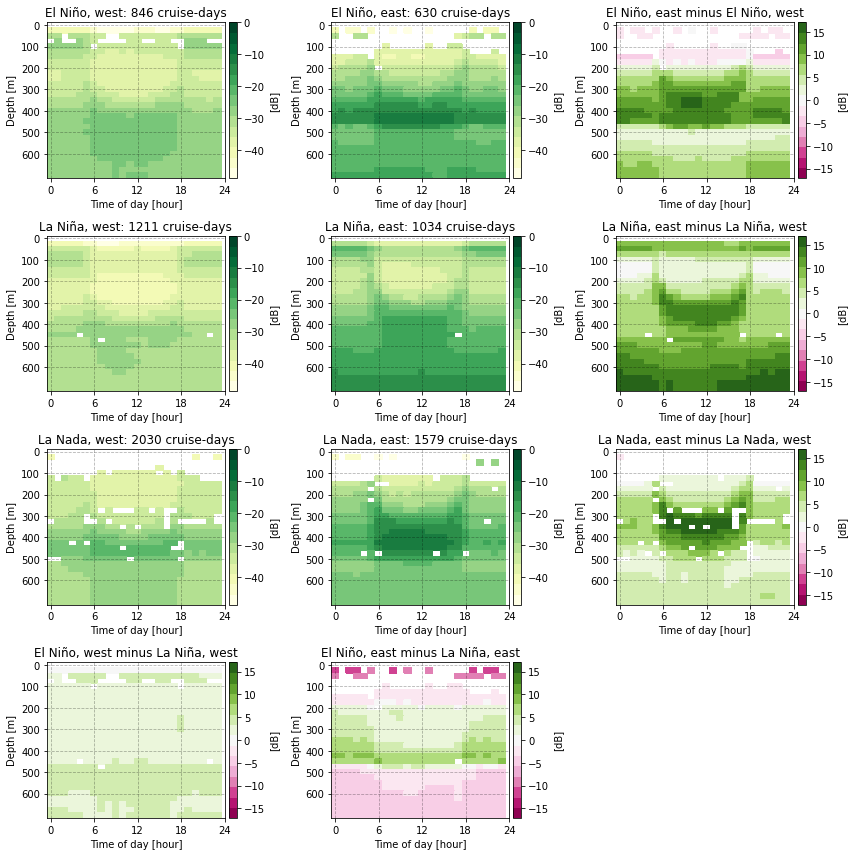

In [15]:
# - Average (AKA composite) all profiles over each Sv cruise-days matrix
# (std_depths[0:29] goes from 0 to 700 m)
Svcd_mean_all = 6*[None]
for imat in range(0,len(Svcd_raw_all_xr)):
    Svcd_mean_all[imat] = Svcd_raw_all_xr[imat].isel(
        depth=np.arange(0,29)).mean(dim='cruise_day')

# - Define plot parameters
Svcd_xrnow = [Svcd_raw_enw_xr, Svcd_raw_ene_xr, Svcd_raw_lnw_xr,
                  Svcd_raw_lne_xr, Svcd_raw_naw_xr, Svcd_raw_nae_xr]
plottitlesnow = ['El Niño, west', 'El Niño, east', 'La Niña, west',
                 'La Niña, east', 'La Nada, west', 'La Nada, east'] 
gridls = '--'; gridcolor = 'black'; gridalpha = 0.3
xticksnow = np.arange(0,30,6); yticksnow = np.arange(0,700,100)
seqcmapnow = plt.cm.get_cmap('YlGn',15)
divcmapnow = plt.cm.get_cmap('PiYG',15)

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))

# - Plot EN/LN/NA east and west mean Sv cruise-day cross sections (xsecs)
isp = 0
arrnow = np.array(Svcd_mean_all)
vmaxnow = 0; vminnow = np.nanmin(arrnow[~np.isinf(arrnow)])
for yax in np.arange(0,3):
    for xax in np.arange(0,2):
        Svcd_mean_all[isp].plot(ax=axes[yax][xax],
            y='depth', yincrease=False, vmin=vminnow, vmax=vmaxnow,
            cmap=seqcmapnow, cbar_kwargs={'pad': 0.02, 'label': '[dB]'})
        axes[yax][xax].set_xlabel('Time of day [hour]')
        axes[yax][xax].set_ylabel('Depth [m]')
        axes[yax][xax].set_title(plottitlesnow[isp] +
            ': ' + str(Svcd_xrnow[isp].shape[2]) + ' cruise-days')
        axes[yax][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
        axes[yax][xax].set_xticks(xticksnow)
        axes[yax][xax].set_yticks(yticksnow)
        isp += 1

# ---- Compute figure-wide vmins and vmaxs for diverging subplots
# - Compute EN/LN/NA east minus west mean Svcd xsecs (right column of subplots)
isp = 0
vminmaxnow = 0
for yax in np.arange(0,3):
    Svdiffnow = Svcd_mean_all[isp+1]-Svcd_mean_all[isp]
    vminmaxnow = max(np.nanmax(abs(Svdiffnow.where(~np.isinf(Svdiffnow)))), vminmaxnow)
    isp += 2
# - Compute LN minus EN mean Svcd xsecs (bottom row of subplots)
isp = 0
for xax in np.arange(0,2):
    Svdiffnow = Svcd_mean_all[isp]-Svcd_mean_all[isp+2]
    vminmaxnow = max(np.nanmax(abs(Svdiffnow.where(~np.isinf(Svdiffnow)))), vminmaxnow)
    isp += 1

# - Compute and plot EN/LN/NA east minus west mean Svcd xsecs (right column of subplots)
isp = 0
for yax in np.arange(0,3):
    Svdiffnow = Svcd_mean_all[isp+1]-Svcd_mean_all[isp]
    Svdiffnow.plot(ax=axes[yax][xax+1], y='depth', yincrease=False,
                   vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow,
                   cbar_kwargs={'pad': 0.02, 'label': '[dB]'})
    axes[yax][xax+1].set_xlabel('Time of day [hour]')
    axes[yax][xax+1].set_ylabel('Depth [m]')
    axes[yax][xax+1].set_title(plottitlesnow[isp+1] + ' minus ' + plottitlesnow[isp])
    axes[yax][xax+1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax][xax+1].set_xticks(xticksnow)
    axes[yax][xax+1].set_yticks(yticksnow)
    isp += 2

# - Compute and plot LN minus EN mean Svcd xsecs (bottom row of subplots)
isp = 0
for xax in np.arange(0,2):
    Svdiffnow = Svcd_mean_all[isp]-Svcd_mean_all[isp+2]
    Svdiffnow.plot(ax=axes[yax+1][xax], y='depth', yincrease=False,
                   vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow,
                   cbar_kwargs={'pad': 0.02, 'label': '[dB]'})
    axes[yax+1][xax].set_xlabel('Time of day [hour]')
    axes[yax+1][xax].set_ylabel('Depth [m]')
    axes[yax+1][xax].set_title(plottitlesnow[isp] + ' minus ' + plottitlesnow[isp+2])
    axes[yax+1][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax+1][xax].set_xticks(xticksnow)
    axes[yax+1][xax].set_yticks(yticksnow)
    isp += 1
axes[3,2].axis('off')

fig.tight_layout()
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_Svcd_raw_ENSO_avgs.png',
            bbox_inches='tight', pad_inches = 0, dpi = 300)

### Compute and plot overall mean, stdev, ENSO composite minus mean, ENSO composite minus La Nada Sv cruise-days

In [16]:
Svcd_mean_w = (Svcd_raw_enw_xr.mean(dim='cruise_day')*Svcd_icd[0] + \
                Svcd_raw_lnw_xr.mean(dim='cruise_day')*Svcd_icd[2] + \
                Svcd_raw_naw_xr.mean(dim='cruise_day')*Svcd_icd[4]) \
                /(Svcd_icd[0]+Svcd_icd[2]+Svcd_icd[4])
Svcd_mean_w = Svcd_mean_w.isel(depth=np.arange(0,29))
Svcd_mean_e = (Svcd_raw_ene_xr.mean(dim='cruise_day')*Svcd_icd[1] + \
                Svcd_raw_lne_xr.mean(dim='cruise_day')*Svcd_icd[3] + \
                Svcd_raw_nae_xr.mean(dim='cruise_day')*Svcd_icd[5]) \
                /(Svcd_icd[1]+Svcd_icd[3]+Svcd_icd[5])
Svcd_mean_e = Svcd_mean_e.isel(depth=np.arange(0,29))
Svcd_enmsmean_w = Svcd_mean_all[0] - Svcd_mean_w
Svcd_lnmsmean_w = Svcd_mean_all[2] - Svcd_mean_w
Svcd_enmsmean_e = Svcd_mean_all[1] - Svcd_mean_e
Svcd_lnmsmean_e = Svcd_mean_all[3] - Svcd_mean_e
Svcd_std_w = np.nanstd(np.dstack([Svcd_raw_enw_xr.isel(depth=np.arange(0,29)),
                                  Svcd_raw_lnw_xr.isel(depth=np.arange(0,29)),
                                  Svcd_raw_naw_xr.isel(depth=np.arange(0,29))]), axis=2)
Svcd_std_e = np.nanstd(np.dstack([Svcd_raw_ene_xr.isel(depth=np.arange(0,29)),
                                  Svcd_raw_lne_xr.isel(depth=np.arange(0,29)),
                                  Svcd_raw_nae_xr.isel(depth=np.arange(0,29))]), axis=2)

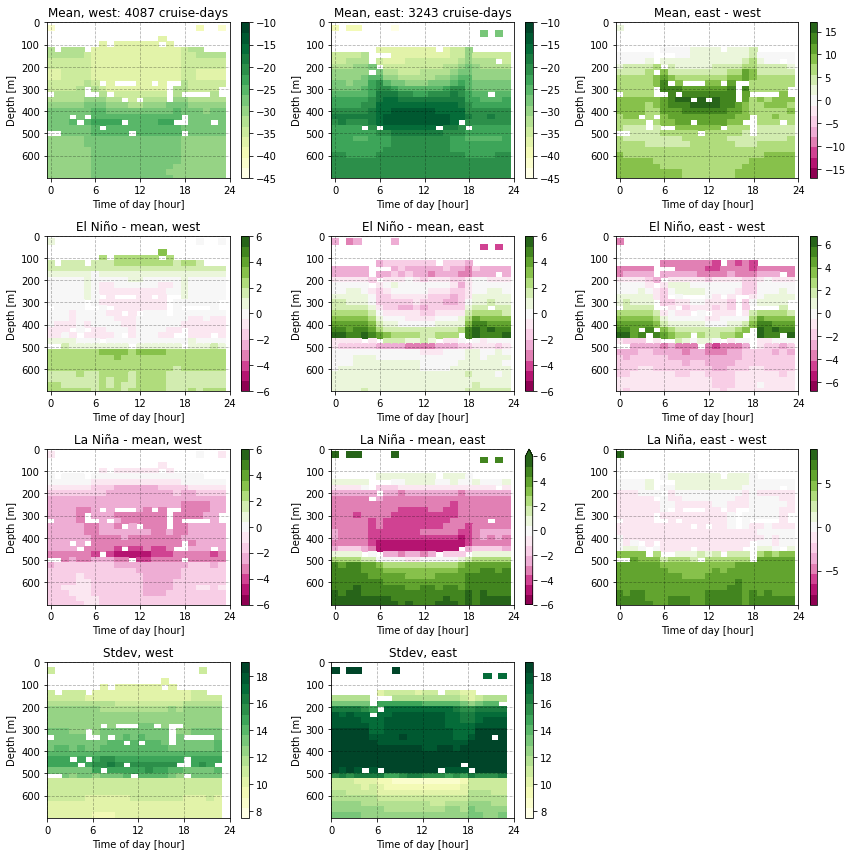

In [17]:
gridls = '--'; gridcolor = 'black'; gridalpha = 0.3
xticksnow = np.arange(0,30,6); yticksnow = np.arange(0,700,100)
seqcmapnow = plt.cm.get_cmap('YlGn',15)
divcmapnow = plt.cm.get_cmap('PiYG',15)

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))

# ---- Plot overall means in west and east
vminnow, vmaxnow = -45, -10
# - West
Svcd_mean_w.plot(ax=axes[0][0], y='depth', yincrease=False,
                 vmin=vminnow, vmax=vmaxnow, cmap=seqcmapnow)
axes[0][0].set_xlabel('Time of day [hour]')
axes[0][0].set_ylabel('Depth [m]')
axes[0][0].set_title('Mean, west: ' + 
    str(Svcd_icd[0]+Svcd_icd[2]+Svcd_icd[4]) + ' cruise-days')
axes[0][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][0].set_xticks(xticksnow)
axes[0][0].set_yticks(yticksnow)
axes[0][0].set_ylim([700,0])
# - East
Svcd_mean_e.plot(ax=axes[0][1], y='depth', yincrease=False,
                 vmin=vminnow, vmax=vmaxnow, cmap=seqcmapnow)
axes[0][1].set_xlabel('Time of day [hour]')
axes[0][1].set_ylabel('Depth [m]')
axes[0][1].set_title('Mean, east: ' + 
    str(Svcd_icd[1]+Svcd_icd[3]+Svcd_icd[5]) + ' cruise-days')
axes[0][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][1].set_xticks(xticksnow);
axes[0][1].set_yticks(yticksnow);
axes[0][1].set_ylim([700,0])
# - East minus west
(Svcd_mean_e-Svcd_mean_w).plot(ax=axes[0][2], y='depth', yincrease=False,
    vmin=-17, vmax=17, cmap=divcmapnow)
axes[0][2].set_xlabel('Time of day [hour]')
axes[0][2].set_ylabel('Depth [m]')
axes[0][2].set_title('Mean, east - west')
axes[0][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][2].set_xticks(xticksnow);
axes[0][2].set_yticks(yticksnow);
axes[0][2].set_ylim([700,0])

# ---- Plot El Nino composites minus overall means in west and east
vminnow, vmaxnow = -6, 6
# - West 
Svcd_enmsmean_w.plot(ax=axes[1][0], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[1][0].set_xlabel('Time of day [hour]')
axes[1][0].set_ylabel('Depth [m]')
axes[1][0].set_title('El Niño - mean, west')
axes[1][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][0].set_xticks(xticksnow);
axes[1][0].set_yticks(yticksnow);
axes[1][0].set_ylim([700,0])
# - East 
Svcd_enmsmean_e.plot(ax=axes[1][1], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[1][1].set_xlabel('Time of day [hour]')
axes[1][1].set_ylabel('Depth [m]')
axes[1][1].set_title('El Niño - mean, east')
axes[1][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][1].set_xticks(xticksnow);
axes[1][1].set_yticks(yticksnow);
axes[1][1].set_ylim([700,0])
# - East minus west
(Svcd_enmsmean_e-Svcd_enmsmean_w).plot(ax=axes[1][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[1][2].set_xlabel('Time of day [hour]')
axes[1][2].set_ylabel('Depth [m]')
axes[1][2].set_title('El Niño, east - west')
axes[1][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][2].set_xticks(xticksnow);
axes[1][2].set_yticks(yticksnow);
axes[1][2].set_ylim([700,0])

# ---- Plot La Nina composites minus overall means in west and east
# - West
Svcd_lnmsmean_w.plot(ax=axes[2][0], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[2][0].set_xlabel('Time of day [hour]')
axes[2][0].set_ylabel('Depth [m]')
axes[2][0].set_title('La Niña - mean, west')
axes[2][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][0].set_xticks(xticksnow);
axes[2][0].set_yticks(yticksnow);
axes[2][0].set_ylim([700,0])
# - East
Svcd_lnmsmean_e.plot(ax=axes[2][1], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[2][1].set_xlabel('Time of day [hour]')
axes[2][1].set_ylabel('Depth [m]')
axes[2][1].set_title('La Niña - mean, east')
axes[2][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][1].set_xticks(xticksnow);
axes[2][1].set_yticks(yticksnow);
axes[2][1].set_ylim([700,0])
# - East minus west
(Svcd_lnmsmean_e-Svcd_lnmsmean_w).plot(ax=axes[2][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[2][2].set_xlabel('Time of day [hour]')
axes[2][2].set_ylabel('Depth [m]')
axes[2][2].set_title('La Niña, east - west')
axes[2][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][2].set_xticks(xticksnow);
axes[2][2].set_yticks(yticksnow);
axes[2][2].set_ylim([700,0])

# ---- Plot overall stdevs in east and west
vminnow, vmaxnow = 7.5, 19
# - West
pc = axes[3][0].pcolormesh(np.arange(0,24), std_depths[0:29],
    Svcd_std_w.transpose(), vmin=vminnow, vmax=vmaxnow,
    cmap=seqcmapnow)
plt.colorbar(pc, ax=axes[3][0])
axes[3][0].set_xlabel('Time of day [hour]')
axes[3][0].set_ylabel('Depth [m]')
axes[3][0].set_title('Stdev, west')
axes[3][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[3][0].set_xticks(xticksnow)
axes[3][0].set_yticks(yticksnow)
axes[3][0].set_ylim([700,0])
# - East
pc = axes[3][1].pcolormesh(np.arange(0,24), std_depths[0:29],
    Svcd_std_e.transpose(), vmin=vminnow, vmax=vmaxnow,
    cmap=seqcmapnow)
plt.colorbar(pc, ax=axes[3][1])
axes[3][1].set_xlabel('Time of day [hour]')
axes[3][1].set_ylabel('Depth [m]')
axes[3][1].set_ylim([700,0])
axes[3][1].set_title('Stdev, east')
axes[3][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[3][1].set_xticks(xticksnow)
axes[3][1].set_yticks(yticksnow)
axes[3][1].set_ylim([700,0])

axes[3,2].axis('off')

fig.tight_layout()
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_Svcd_raw_overallmean_ENSOminusoverallmean_stdevs.png',
            bbox_inches='tight', pad_inches = 0, dpi = 300)

# 2.) Analysis method 2 - Canny edge detection + averaging

(41.0, 0.0)

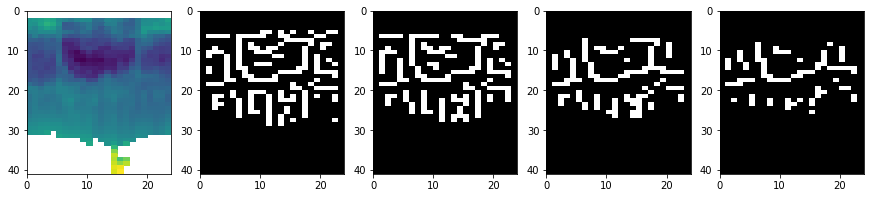

In [18]:
# - Testing to choose sigma value to use in edge detection
# --> After looking at a bunch of cruise-days, 0.25 seems good
fig,axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))
test = Svcd_raw_all_xr[0][:,:,203]
axes[0].pcolormesh(test.transpose())
axes[0].set_ylim(axes[0].get_ylim()[::-1])
test1now = feature.canny(test.values, sigma=0.25)
axes[1].pcolormesh(test1now.transpose(), cmap=cm.gray)
axes[1].set_ylim(axes[1].get_ylim()[::-1])
test1now = feature.canny(test.values, sigma=0.5)
axes[2].pcolormesh(test1now.transpose(), cmap=cm.gray)
axes[2].set_ylim(axes[2].get_ylim()[::-1])
test1now = feature.canny(test.values, sigma=0.75)
axes[3].pcolormesh(test1now.transpose(), cmap=cm.gray)
axes[3].set_ylim(axes[3].get_ylim()[::-1])
test1now = feature.canny(test.values, sigma=1)
axes[4].pcolormesh(test1now.transpose(), cmap=cm.gray)
axes[4].set_ylim(axes[4].get_ylim()[::-1])

In [19]:
# - Run edge detection on all cruise-days 
# Key: Svcd_raw_all = [Svcd_raw_enw_xr, Svcd_raw_ene_xr, Svcd_raw_lnw_xr, 
#                      Svcd_raw_lne_xr, Svcd_raw_naw_xr, Svcd_raw_nae_xr],
#      Svcd_ed_all = [Svcd_ed_enw_xr, Svcd_ed_ene_xr, Svcd_ed_lnw_xr,
#                     Svcd_ed_lne_xr, Svcd_ed_naw_xr, Svcd_ed_nae_xr]
Svcd_ed_all = [None]*6
sigmanow = 0.25
for imat in np.arange(0,len(Svcd_ed_all)):
    for icd in np.arange(0,Svcd_raw_all_xr[imat].shape[2]):
        Svcd_slicenow = Svcd_raw_all_xr[imat][:,:,icd]
        Svcd_ednow = feature.canny(Svcd_slicenow.values, sigma=sigmanow)
        if icd==0:
            Svcd_ed_all[imat] = Svcd_ednow
        else:
            Svcd_ed_all[imat] = np.dstack([Svcd_ed_all[imat], Svcd_ednow])

In [20]:
# - Clean up and package Svcd_ed variables into DataArrays
midxnow = 0
Svcd_ed_enw_xr = xr.DataArray(Svcd_ed_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_ed_all[midxnow].shape[2])})
Svcd_ed_enw_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_edges_el_nino_WEP.nc')

midxnow = 1
Svcd_ed_ene_xr = xr.DataArray(Svcd_ed_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_ed_all[midxnow].shape[2])})
Svcd_ed_ene_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_edges_el_nino_EEP.nc')

midxnow = 2
Svcd_ed_lnw_xr = xr.DataArray(Svcd_ed_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_ed_all[midxnow].shape[2])})
Svcd_ed_lnw_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_edges_la_nina_WEP.nc')

midxnow = 3
Svcd_ed_lne_xr = xr.DataArray(Svcd_ed_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_ed_all[midxnow].shape[2])})
Svcd_ed_lne_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_edges_la_nina_EEP.nc')

midxnow = 4
Svcd_ed_naw_xr = xr.DataArray(Svcd_ed_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_ed_all[midxnow].shape[2])})
Svcd_ed_naw_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_edges_la_nada_WEP.nc')

midxnow = 5
Svcd_ed_nae_xr = xr.DataArray(Svcd_ed_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_ed_all[midxnow].shape[2])})
Svcd_ed_nae_xr.to_netcdf(dpath+eqpacncfoldername+'jasadcp_Sv_cruise_day_edges_la_nada_EEP.nc')

Svcd_ed_all_xr = [Svcd_ed_enw_xr, Svcd_ed_ene_xr, Svcd_ed_lnw_xr, Svcd_ed_lne_xr, Svcd_ed_naw_xr, Svcd_ed_nae_xr]

### Compute and plot ENSO composite edge-detected (ED) Sv cruise-days

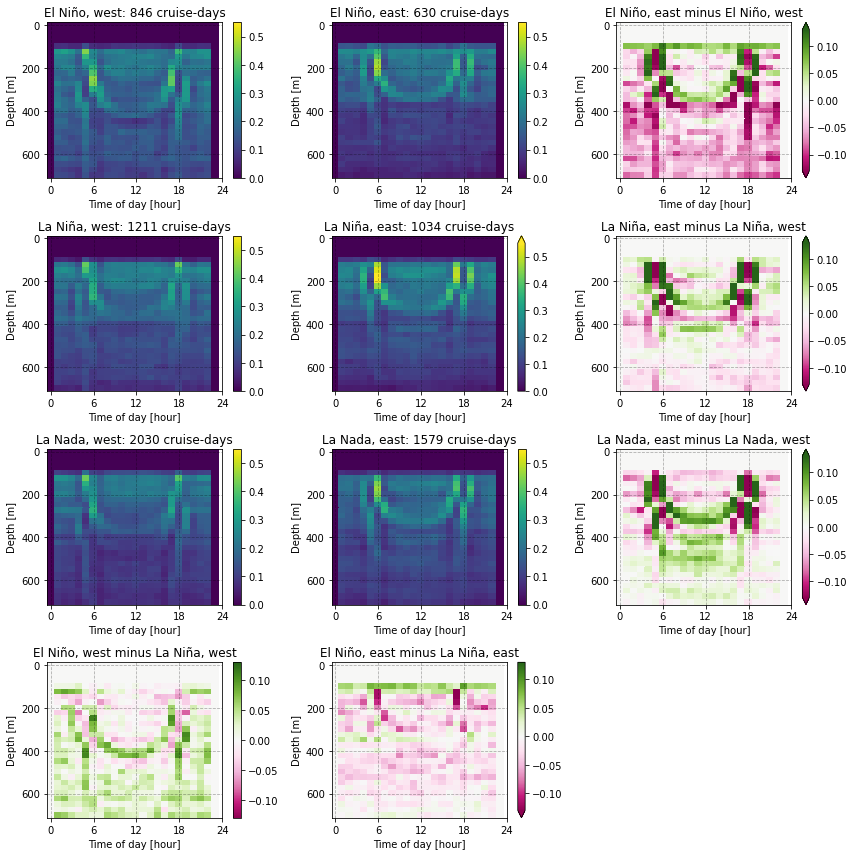

In [21]:
# - Average (AKA composite) all ED profiles over each Sv cruise-days matrix
# (std_depths[0:29] goes from 0 to 700 m)
Svcd_ed_mean_all = 6*[None]
for imat in range(0,len(Svcd_ed_all_xr)):
    Svcd_ed_mean_all[imat] = Svcd_ed_all_xr[imat].isel(
        depth=np.arange(0,29)).mean(dim='cruise_day')

# - Define plot parameters
Svcd_xrnow = [Svcd_ed_enw_xr, Svcd_ed_ene_xr, Svcd_ed_lnw_xr,
                 Svcd_ed_lne_xr, Svcd_ed_naw_xr, Svcd_ed_nae_xr]
plottitlesnow = ['El Niño, west', 'El Niño, east', 'La Niña, west',
                 'La Niña, east', 'La Nada, west', 'La Nada, east'] 
gridls = '--'; gridcolor = 'black'; gridalpha = 0.3
xticksnow = np.arange(0,30,6)
seqcmapnow = cm.viridis
#seqcmapnow = plt.cm.get_cmap('YlGn',15)
divcmapnow = cm.PiYG
#divcmapnow = plt.cm.get_cmap('PiYG',15)

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))

# - Plot EN/LN/NA east and west mean ED cruise-day cross sections (xsecs)
isp = 0
arrnow = np.array(Svcd_ed_mean_all)
vminnow = 0; vmaxnow = 0.55
for yax in np.arange(0,3):
    for xax in np.arange(0,2):
        Svcd_ed_mean_all[isp].plot(ax=axes[yax][xax], y='depth', yincrease=False,
            vmin=vminnow, vmax=vmaxnow, cmap=seqcmapnow)
        axes[yax][xax].set_xlabel('Time of day [hour]')
        axes[yax][xax].set_ylabel('Depth [m]')
        axes[yax][xax].set_title(plottitlesnow[isp] +
            ': ' + str(Svcd_xrnow[isp].shape[2]) + ' cruise-days')
        axes[yax][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
        axes[yax][xax].set_xticks(xticksnow)
        isp += 1

vminmaxnow = 0.13

# - Compute and plot EN/LN/NA east minus west mean ED xsecs (right column of subplots)
isp = 0
for yax in np.arange(0,3):
    Svdiffnow = Svcd_ed_mean_all[isp+1]-Svcd_ed_mean_all[isp]
    Svdiffnow.plot(ax=axes[yax][xax+1], y='depth', yincrease=False,
        vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow)
    axes[yax][xax+1].set_xlabel('Time of day [hour]')
    axes[yax][xax+1].set_ylabel('Depth [m]')
    axes[yax][xax+1].set_title(plottitlesnow[isp+1] + ' minus ' + plottitlesnow[isp])
    axes[yax][xax+1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax][xax+1].set_xticks(xticksnow)
    isp += 2

# - Compute and plot LN minus EN mean ED xsecs (bottom row of subplots)
isp = 0
for xax in np.arange(0,2):
    Svdiffnow = Svcd_ed_mean_all[isp]-Svcd_ed_mean_all[isp+2]
    Svdiffnow.plot(ax=axes[yax+1][xax], y='depth', yincrease=False,
        vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow)
    axes[yax+1][xax].set_xlabel('Time of day [hour]')
    axes[yax+1][xax].set_ylabel('Depth [m]')
    axes[yax+1][xax].set_title(plottitlesnow[isp] + ' minus ' + plottitlesnow[isp+2])
    axes[yax+1][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax+1][xax].set_xticks(xticksnow)
    isp += 1
axes[3,2].axis('off')

fig.tight_layout()
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_Svcd_edges_sigma' + str(sigmanow) + '_ENSO_avgs.png',
            bbox_inches='tight', pad_inches = 0, dpi = 300)

### Compute and plot overall mean, stdev, ENSO composite minus mean, ENSO composite minus La Nada ED Sv cruise-days

In [22]:
Svcd_ed_mean_w = (Svcd_ed_enw_xr.mean(dim='cruise_day')*Svcd_icd[0] + \
                Svcd_ed_lnw_xr.mean(dim='cruise_day')*Svcd_icd[2] + \
                Svcd_ed_naw_xr.mean(dim='cruise_day')*Svcd_icd[4]) \
                /(Svcd_icd[0]+Svcd_icd[2]+Svcd_icd[4])
Svcd_ed_mean_w = Svcd_ed_mean_w.isel(depth=np.arange(0,29))
Svcd_ed_mean_e = (Svcd_ed_ene_xr.mean(dim='cruise_day')*Svcd_icd[1] + \
                Svcd_ed_lne_xr.mean(dim='cruise_day')*Svcd_icd[3] + \
                Svcd_ed_nae_xr.mean(dim='cruise_day')*Svcd_icd[5]) \
                /(Svcd_icd[1]+Svcd_icd[3]+Svcd_icd[5])
Svcd_ed_mean_e = Svcd_ed_mean_e.isel(depth=np.arange(0,29))
Svcd_ed_enmsmean_w = Svcd_ed_mean_all[0] - Svcd_ed_mean_w
Svcd_ed_lnmsmean_w = Svcd_ed_mean_all[2] - Svcd_ed_mean_w
Svcd_ed_enmsmean_e = Svcd_ed_mean_all[1] - Svcd_ed_mean_e
Svcd_ed_lnmsmean_e = Svcd_ed_mean_all[3] - Svcd_ed_mean_e
Svcd_ed_std_w = np.nanstd(np.dstack([Svcd_ed_enw_xr.isel(depth=np.arange(0,29)),
                                  Svcd_ed_lnw_xr.isel(depth=np.arange(0,29)),
                                  Svcd_ed_naw_xr.isel(depth=np.arange(0,29))]), axis=2)
Svcd_ed_std_e = np.nanstd(np.dstack([Svcd_ed_ene_xr.isel(depth=np.arange(0,29)),
                                  Svcd_ed_lne_xr.isel(depth=np.arange(0,29)),
                                  Svcd_ed_nae_xr.isel(depth=np.arange(0,29))]), axis=2)

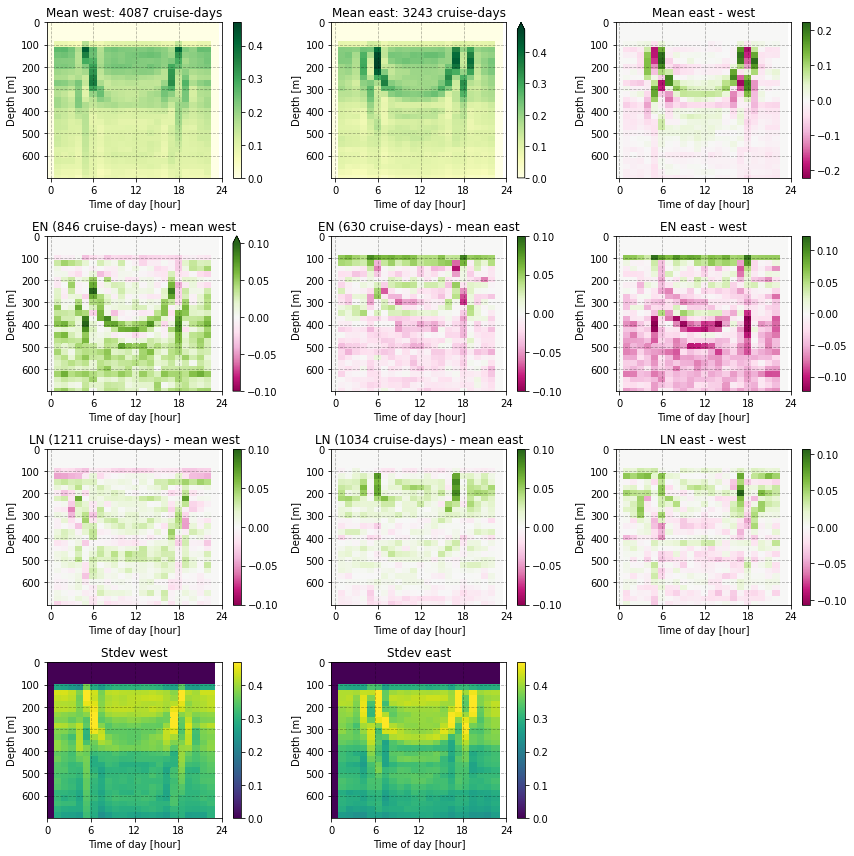

In [23]:
gridls = '--'; gridcolor = 'black'; gridalpha = 0.3
xticksnow = np.arange(0,30,6); yticksnow = np.arange(0,700,100)
divcmapnow = cm.PiYG
seqcmapnow = cm.YlGn

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))

# ---- Plot overall means in west and east
vminnow, vmaxnow = 0, 0.47
# - West
Svcd_ed_mean_w.plot(ax=axes[0][0], y='depth', yincrease=False,
    vmin=vminnow, vmax=vmaxnow, cmap=seqcmapnow)
axes[0][0].set_xlabel('Time of day [hour]')
axes[0][0].set_ylabel('Depth [m]')
axes[0][0].set_title('Mean west: ' +
    str(Svcd_icd[0]+Svcd_icd[2]+Svcd_icd[4]) + ' cruise-days')
axes[0][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][0].set_xticks(xticksnow)
axes[0][0].set_yticks(yticksnow);
axes[0][0].set_ylim([700,0])
# - East
Svcd_ed_mean_e.plot(ax=axes[0][1], y='depth', yincrease=False,
    vmin=vminnow, vmax=vmaxnow, cmap=seqcmapnow)
axes[0][1].set_xlabel('Time of day [hour]')
axes[0][1].set_ylabel('Depth [m]')
axes[0][1].set_title('Mean east: ' + 
    str(Svcd_icd[1]+Svcd_icd[3]+Svcd_icd[5]) + ' cruise-days')
axes[0][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][1].set_xticks(xticksnow);
axes[0][1].set_yticks(yticksnow);
axes[0][1].set_ylim([700,0])
# - East minus west
(Svcd_ed_mean_e-Svcd_ed_mean_w).plot(ax=axes[0][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[0][2].set_xlabel('Time of day [hour]')
axes[0][2].set_ylabel('Depth [m]')
axes[0][2].set_title('Mean east - west')
axes[0][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][2].set_xticks(xticksnow);
axes[0][2].set_yticks(yticksnow);
axes[0][2].set_ylim([700,0])

vminnow, vmaxnow = -0.1, 0.1

# ---- Plot El Nino composites minus overall means in west and east
# - West
Svcd_ed_enmsmean_w.plot(ax=axes[1][0], y='depth', yincrease=False,
    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[1][0].set_xlabel('Time of day [hour]')
axes[1][0].set_ylabel('Depth [m]')
axes[1][0].set_title('EN (' + str(Svcd_icd[0]) + ' cruise-days) - mean west')
axes[1][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][0].set_xticks(xticksnow);
axes[1][0].set_yticks(yticksnow);
axes[1][0].set_ylim([700,0])
# - East
Svcd_ed_enmsmean_e.plot(ax=axes[1][1], y='depth', yincrease=False,
    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[1][1].set_xlabel('Time of day [hour]')
axes[1][1].set_ylabel('Depth [m]')
axes[1][1].set_title('EN (' + str(Svcd_icd[1]) + ' cruise-days) - mean east')
axes[1][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][1].set_xticks(xticksnow);
axes[1][1].set_yticks(yticksnow);
axes[1][1].set_ylim([700,0])
# - East minus west
(Svcd_ed_enmsmean_e-Svcd_ed_enmsmean_w).plot(ax=axes[1][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[1][2].set_xlabel('Time of day [hour]')
axes[1][2].set_ylabel('Depth [m]')
axes[1][2].set_title('EN east - west')
axes[1][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][2].set_xticks(xticksnow);
axes[1][2].set_yticks(yticksnow);
axes[1][2].set_ylim([700,0])

# ---- Plot La Nina composites minus overall means in west and east
# - West
Svcd_ed_lnmsmean_w.plot(ax=axes[2][0], y='depth', yincrease=False,
    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[2][0].set_xlabel('Time of day [hour]')
axes[2][0].set_ylabel('Depth [m]')
axes[2][0].set_title('LN (' + str(Svcd_icd[2]) + ' cruise-days) - mean west')
axes[2][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][0].set_xticks(xticksnow);
axes[2][0].set_yticks(yticksnow);
axes[2][0].set_ylim([700,0])
# - East
Svcd_ed_lnmsmean_e.plot(ax=axes[2][1], y='depth', yincrease=False,
    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[2][1].set_xlabel('Time of day [hour]')
axes[2][1].set_ylabel('Depth [m]')
axes[2][1].set_title('LN (' + str(Svcd_icd[3]) + ' cruise-days) - mean east')
axes[2][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][1].set_xticks(xticksnow);
axes[2][1].set_yticks(yticksnow);
axes[2][1].set_ylim([700,0])
# - East minus west
(Svcd_ed_lnmsmean_e-Svcd_ed_lnmsmean_w).plot(ax=axes[2][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[2][2].set_xlabel('Time of day [hour]')
axes[2][2].set_ylabel('Depth [m]')
axes[2][2].set_title('LN east - west')
axes[2][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][2].set_xticks(xticksnow);
axes[2][2].set_yticks(yticksnow);
axes[2][2].set_ylim([700,0])

# ---- Plot overall stdevs in east and west
vminnow, vmaxnow = 0, 0.47
# - West
pc = axes[3][0].pcolormesh(np.arange(0,24), std_depths[0:29], Svcd_ed_std_w.transpose(),
    vmin=vminnow, vmax=vmaxnow, cmap=cm.viridis)
plt.colorbar(pc, ax=axes[3][0])
axes[3][0].set_xlabel('Time of day [hour]')
axes[3][0].set_ylabel('Depth [m]')
axes[3][0].set_title('Stdev west')
axes[3][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[3][0].set_xticks(xticksnow);
axes[3][0].set_yticks(yticksnow);
axes[3][0].set_ylim([700,0])
# - East
pc = axes[3][1].pcolormesh(np.arange(0,24), std_depths[0:29], Svcd_ed_std_e.transpose(),
    vmin=vminnow, vmax=vmaxnow, cmap=cm.viridis)
plt.colorbar(pc, ax=axes[3][1])
axes[3][1].set_xlabel('Time of day [hour]')
axes[3][1].set_ylabel('Depth [m]')
axes[3][1].set_ylim([700,0])
axes[3][1].set_title('Stdev east')
axes[3][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[3][1].set_xticks(xticksnow);
axes[3][1].set_yticks(yticksnow);
axes[3][1].set_ylim([700,0])

axes[3,2].axis('off')

fig.tight_layout()
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_Svcd_edges_sigma' + str(sigmanow) + '_overallmean_ENSOminusoverallmean_stdevs.png',
            bbox_inches='tight', pad_inches = 0, dpi = 300)